In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

Let's begin by loading in the datasets.

In [3]:
democrat_info = pd.read_csv('dem_candidates.csv')
republican_info = pd.read_csv('rep_candidates.csv')

In [4]:
republican_info['Party'] = 'Republican'
democrat_info['Party'] = 'Democrat'

We will combine the two datasets for the two parties.

In [5]:
df = pd.concat([republican_info,democrat_info], ignore_index=True)
df

,Candidate,Gender,Race 1,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,...,Winning for Women,Party,EMILY's List,Justice Dems,Indivisible,PCCC,Our Revolution,Sunrise,Sanders,AOC
0,"Aditya ""A.D."" Atholi",Male,Asian (Indian),NaN,NaN,No,No,Texas,3/1/22,Representative,...,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Joe McDaniel,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nathaniel Moran,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,John Porro,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Dan Crenshaw,Male,White,NaN,NaN,Yes,No,Texas,3/1/22,Representative,...,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2671,Matthew A. Brown,Male,White,NaN,NaN,No,Yes,Rhode Island,9/13/22,Governor,...,NaN,Democrat,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2672,Helena Buonanno Foulkes,Female,White,NaN,NaN,No,Yes,Rhode Island,9/13/22,Governor,...,NaN,Democrat,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2673,Nellie M. Gorbea,Female,Latino (Puerto Rican),NaN,NaN,No,Yes,Rhode Island,9/13/22,Governor,...,NaN,Democrat,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2674,Daniel J. McKee,Male,White,NaN,NaN,Yes,No,Rhode Island,9/13/22,Governor,...,NaN,Democrat,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
pd.set_option('display.max_columns', None)
df

,Candidate,Gender,Race 1,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,District,Primary Votes,Primary %,Primary Outcome,Runoff Votes,Runoff %,Runoff Outcome,2020 Election Stance,Trump,Trump Date,Club for Growth,Party Committee,Renew America,E-PAC,VIEW PAC,Maggie's List,Winning for Women,Party,EMILY's List,Justice Dems,Indivisible,PCCC,Our Revolution,Sunrise,Sanders,AOC
0,"Aditya ""A.D."" Atholi",Male,Asian (Indian),NaN,NaN,No,No,Texas,3/1/22,Representative,1,"6,186",8%,Lost,NaN,NaN,NaN,No comment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Joe McDaniel,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,1,"19,708",24%,Lost,NaN,NaN,NaN,Raised questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nathaniel Moran,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,1,"51,312",63%,Won,NaN,NaN,NaN,Raised questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,John Porro,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,1,"4,238",5%,Lost,NaN,NaN,NaN,No comment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Dan Crenshaw,Male,White,NaN,NaN,Yes,No,Texas,3/1/22,Representative,2,"45,863",74%,Won,NaN,NaN,NaN,Accepted with reservations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2671,Matthew A. Brown,Male,White,NaN,NaN,No,Yes,Rhode Island,9/13/22,Governor,NaN,"9,021",8%,Lost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,Democrat,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2672,Helena Buonanno Foulkes,Female,White,NaN,NaN,No,Yes,Rhode Island,9/13/22,Governor,NaN,"33,931",30%,Lost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,Democrat,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2673,Nellie M. Gorbea,Female,Latino (Puerto Rican),NaN,NaN,No,Yes,Rhode Island,9/13/22,Governor,NaN,"29,811",26%,Lost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,Democrat,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2674,Daniel J. McKee,Male,White,NaN,NaN,Yes,No,Rhode Island,9/13/22,Governor,NaN,"37,288",33%,Won,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Democrat,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
len(df)

2676

# EDA Q1

**Question 1:** Did receiving a high-profile endorsement causally increase a candidate’s probability of winning their primary election?


In [8]:
def compute_win_status(row):
    if row["Primary Outcome"] == "Won":
        return 1
    elif row["Primary Outcome"] == "Made runoff" and row["Runoff Outcome"] == "Won":
        return 1
    else:
        return 0

df["won_election"] = df.apply(compute_win_status, axis=1)

In [9]:
def clean_endorsement(value):
    if pd.isna(value):
        return "N/A"
    value = value.strip()
    return "Yes" if value == "Yes" else "No"

## Endorsement by Sanders

In [10]:
df["Sanders_clean"] = df["Sanders"].apply(clean_endorsement)
dem_df = df[df["Party"].str.strip() == "Democrat"]

In [11]:
print("Democrat Sanders Endorsement Counts:")
print(dem_df["Sanders_clean"].value_counts(dropna=False), "\n")

Democrat Sanders Endorsement Counts:
Sanders_clean
N/A    975
No      82
Yes     20
Name: count, dtype: int64 



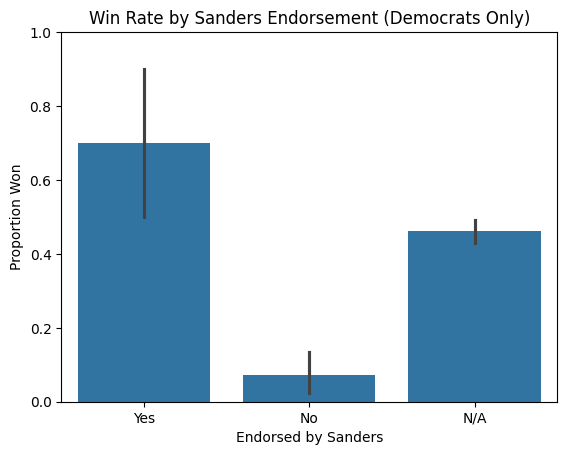

In [12]:
sns.barplot(x="Sanders_clean", y="won_election", data=dem_df, order=["Yes", "No", "N/A"])
plt.title("Win Rate by Sanders Endorsement (Democrats Only)")
plt.xlabel("Endorsed by Sanders")
plt.ylabel("Proportion Won")
plt.ylim(0, 1)
plt.show()

Senator Bernie Sanders is one of the highest-profile Democrat leaders, with mass appeal across the country, with millions of followers across several social media followers. We can clearly observe a significantly higher win rate of approximately 0.7 for Democrat candidates endorsed by Sanders. Candidates not endorsed by Sanders had a very low win rate of approximately 0.1, while those in the N/A category averaged a win rate around 0.5. We would like to examine whether this disparity is caused by Sanders' endorsement, or whether it is due to other factors.

## Endorsement by AOC

In [13]:
df["AOC_clean"] = df["AOC"].apply(clean_endorsement)
dem_df = df[df["Party"].str.strip() == "Democrat"]

In [14]:
print("Democrat AOC Endorsement Counts:")
print(dem_df["AOC_clean"].value_counts(dropna=False), "\n")

Democrat AOC Endorsement Counts:
AOC_clean
N/A    1039
No       29
Yes       9
Name: count, dtype: int64 



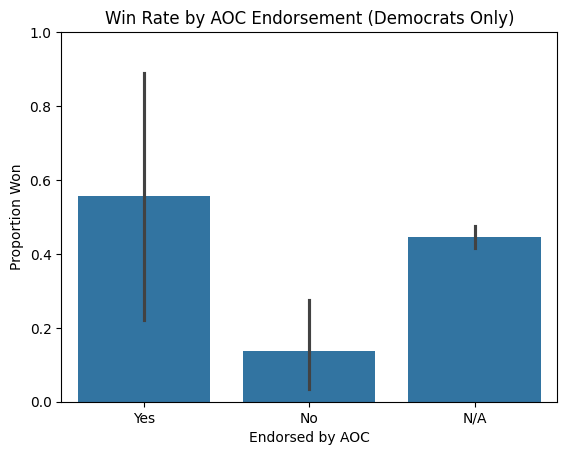

In [15]:
dem_df = df[df["Party"].str.strip() == "Democrat"]

sns.barplot(x="AOC_clean", y="won_election", data=dem_df, order=["Yes", "No", "N/A"])
plt.title("Win Rate by AOC Endorsement (Democrats Only)")
plt.xlabel("Endorsed by AOC")
plt.ylabel("Proportion Won")
plt.ylim(0, 1)
plt.show()

Similar to Sanders, Representative Alexandria Ocasio-Cortez (AOC) is another progressive leader with a large reach. However, she is significantly younger, female, and a minority, which may affect the power of her endorsements. We observe a significant difference between candidates endorsed by AOC and those not endorsed, but the proportion of those who won is approximately 0.55, which is lower than the 0.7 observed for Sanders. We would like to see whether AOC's endorsements cause successful primaries, as well as compare the effects of her endorsement to the effects of endorsements from Bernie Sanders.

## Endorsement by Trump

In [16]:
df["Trump_clean"] = df["Trump"].apply(clean_endorsement)
rep_df = df[df["Party"].str.strip() == "Republican"]

In [17]:
print("Republican Trump Endorsement Counts:")
print(rep_df["Trump_clean"].value_counts(dropna=False))

Republican Trump Endorsement Counts:
Trump_clean
N/A    1002
No      409
Yes     188
Name: count, dtype: int64


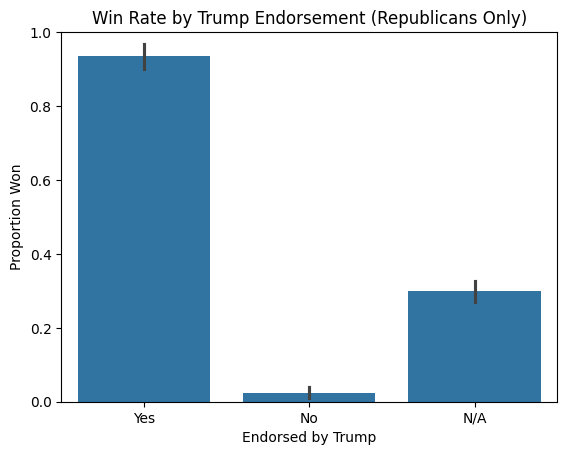

In [18]:
rep_df = df[df["Party"].str.strip() == "Republican"]

sns.barplot(x="Trump_clean", y="won_election", data=rep_df, order=["Yes", "No", "N/A"])
plt.title("Win Rate by Trump Endorsement (Republicans Only)")
plt.xlabel("Endorsed by Trump")
plt.ylabel("Proportion Won")
plt.ylim(0, 1)
plt.show()

President Trump is undoubtedly the most influential figure in the modern Republican Party. Candidates endorsed by Trump had an over 0.9 win proportion, which seems to indicate that his endorsement is extremely impactful. We would like to assess whether this relationship is causal or not. It may also be interesting to see whether success rates changed while Trump was in office or not if we can get access to data from primary cycles from Trump's first term, as the 2022 data comes from after he had lost the presidential election to Joe Biden.

## Comparison

Trump Endorsement Stats:
        count       mean        std  min   25%   50%    75%    max
Trump                                                             
No     1402.0  24.708987  27.665733  0.0   5.0  14.0   34.0  100.0
Yes     187.0  76.128342  22.803617  0.0  65.5  78.0  100.0  100.0

AOC Endorsement Stats:
      count       mean        std   min   25%   50%   75%    max
AOC                                                             
No   1067.0  44.060918  38.447755   0.0   7.0  31.0  88.0  100.0
Yes     9.0  49.555556  15.355057  33.0  37.0  47.0  61.0   78.0

Sanders Endorsement Stats: 
          count       mean        std   min   25%   50%   75%    max
Sanders                                                             
No       1056.0  43.928030  38.542087   0.0   7.0  31.0  88.0  100.0
Yes        19.0  54.157895  22.106468  20.0  37.5  50.0  65.0  100.0


C:\Users\ishan\AppData\Local\Temp\ipykernel_47140\1619282662.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_trump.groupby("Trump")["Vote Share"].describe())
C:\Users\ishan\AppData\Local\Temp\ipykernel_47140\1619282662.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_aoc.groupby("AOC")["Vote Share"].describe())
C:\Users\ishan\AppData\Local\Temp\ipykernel_47140\1619282662.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

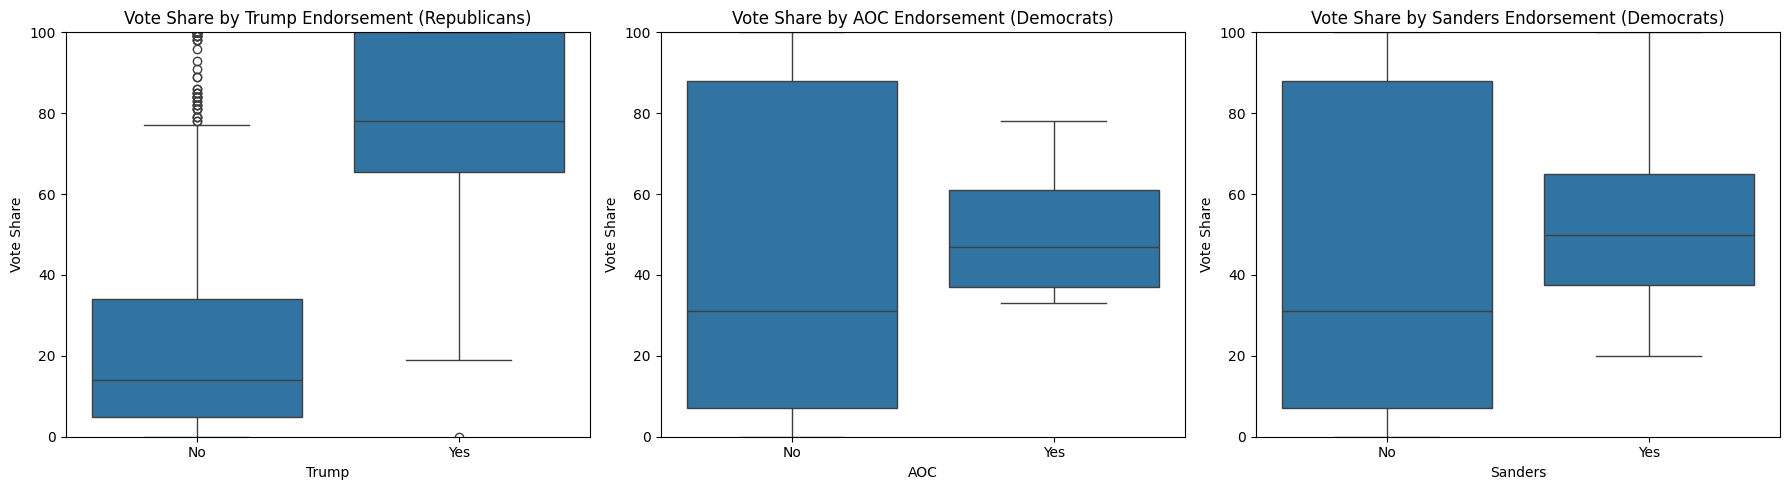

In [19]:
df["Vote Share"] = pd.to_numeric(df["Primary %"].astype(str).str.replace('%', ''), errors='coerce')

df["Trump"] = df["Trump"].fillna("No")
df["AOC"] = df["AOC"].fillna("No")
df["Sanders"] = df["Sanders"].fillna("No")

for col in ["Trump", "AOC", "Sanders"]:
    df[col] = pd.Categorical(df[col], categories=["No", "Yes"], ordered=True)

df_trump = df[(df["Party"] == "Republican") & df["Trump"].isin(["Yes", "No"])].copy()
df_aoc = df[(df["Party"] == "Democrat") & df["AOC"].isin(["Yes", "No"])].copy()
df_sanders = df[(df["Party"] == "Democrat") & df["Sanders"].isin(["Yes", "No"])].copy()

print("Trump Endorsement Stats:")
print(df_trump.groupby("Trump")["Vote Share"].describe())
print("\nAOC Endorsement Stats:")
print(df_aoc.groupby("AOC")["Vote Share"].describe())
print("\nSanders Endorsement Stats: ")
print(df_sanders.groupby("Sanders")["Vote Share"].describe())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.4)

sns.boxplot(x="Trump", y="Vote Share", data=df_trump, ax=axes[0])
axes[0].set_title("Vote Share by Trump Endorsement (Republicans)")
axes[0].set_ylim(0, 100)

sns.boxplot(x="AOC", y="Vote Share", data=df_aoc, ax=axes[1])
axes[1].set_title("Vote Share by AOC Endorsement (Democrats)")
axes[1].set_ylim(0, 100)

sns.boxplot(x="Sanders", y="Vote Share", data=df_sanders, ax=axes[2])
axes[2].set_title("Vote Share by Sanders Endorsement (Democrats)")
axes[2].set_ylim(0, 100)

plt.tight_layout()
plt.show()


These box charts support the above graphs, where candidates endorsed by high-profile politicians have a higher vote share. However, this just matches the above data as those endorsed are more likely to win.

Trump Endorsement Stats (Winners Only):
       count       mean        std   min    25%   50%    75%    max
Trump                                                              
No     306.0  67.294118  25.477958  12.0  45.25  65.0  100.0  100.0
Yes    175.0  78.931429  20.391735   0.0  67.00  80.0  100.0  100.0
AOC Endorsement Stats (Winners Only):
     count       mean        std   min   25%   50%    75%    max
AOC                                                             
No   465.0  83.406452  20.365739  20.0  68.0  94.0  100.0  100.0
Yes    5.0  59.000000  13.784049  42.0  50.0  61.0   64.0   78.0
Sanders Endorsement Stats (Winners Only):
         count       mean        std   min   25%   50%    75%    max
Sanders                                                             
No       456.0  83.824561  20.067467  20.0  69.0  94.0  100.0  100.0
Yes       13.0  62.538462  21.415008  28.0  50.0  61.0   69.0  100.0


C:\Users\ishan\AppData\Local\Temp\ipykernel_47140\1954609763.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_trump_winners.groupby("Trump")["Vote Share"].describe())
C:\Users\ishan\AppData\Local\Temp\ipykernel_47140\1954609763.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_aoc_winners.groupby("AOC")["Vote Share"].describe())
C:\Users\ishan\AppData\Local\Temp\ipykernel_47140\1954609763.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

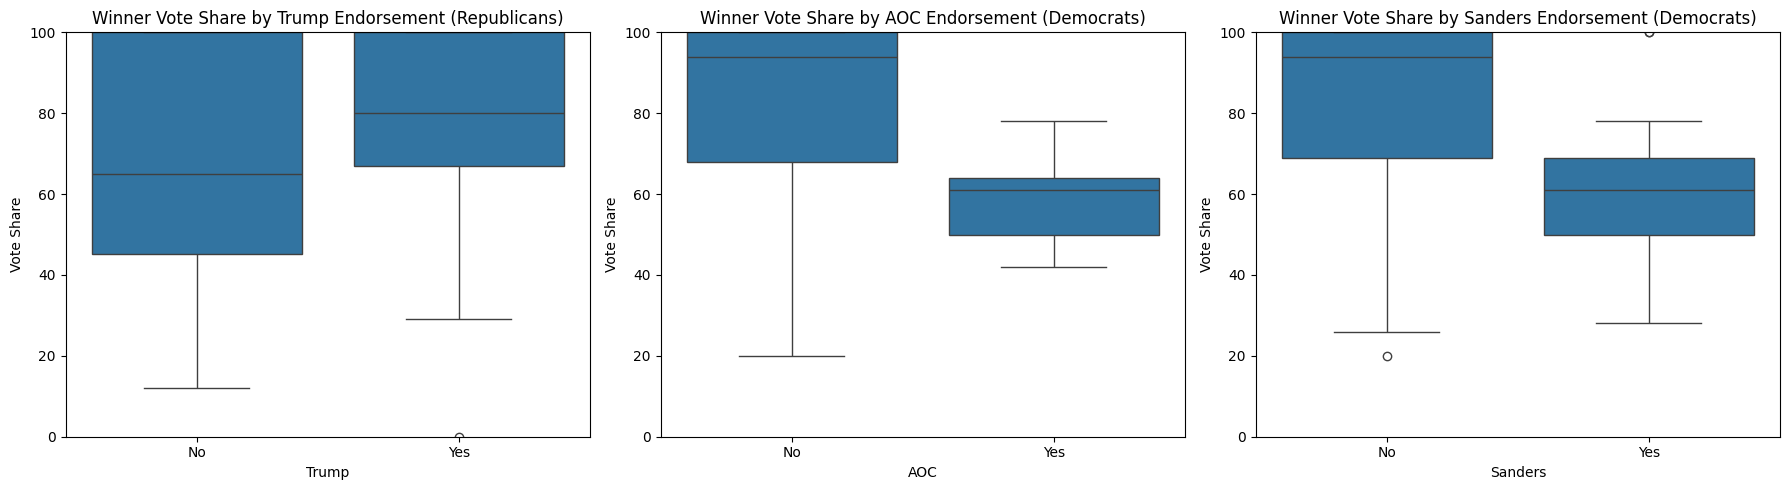

In [20]:
df_trump_winners = df_trump[df_trump["won_election"] == 1].copy()
df_aoc_winners = df_aoc[df_aoc["won_election"] == 1].copy()
df_sanders_winners = df_sanders[df_sanders["won_election"] == 1].copy()

print("Trump Endorsement Stats (Winners Only):")
print(df_trump_winners.groupby("Trump")["Vote Share"].describe())

print("AOC Endorsement Stats (Winners Only):")
print(df_aoc_winners.groupby("AOC")["Vote Share"].describe())

print("Sanders Endorsement Stats (Winners Only):")
print(df_sanders_winners.groupby("Sanders")["Vote Share"].describe())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.4)

sns.boxplot(x="Trump", y="Vote Share", data=df_trump_winners, ax=axes[0])
axes[0].set_title("Winner Vote Share by Trump Endorsement (Republicans)")
axes[0].set_ylim(0, 100)

sns.boxplot(x="AOC", y="Vote Share", data=df_aoc_winners, ax=axes[1])
axes[1].set_title("Winner Vote Share by AOC Endorsement (Democrats)")
axes[1].set_ylim(0, 100)

sns.boxplot(x="Sanders", y="Vote Share", data=df_sanders_winners, ax=axes[2])
axes[2].set_title("Winner Vote Share by Sanders Endorsement (Democrats)")
axes[2].set_ylim(0, 100)

plt.tight_layout()
plt.show()


Trump Endorsement Stats (Losers Only):
        count       mean        std   min    25%   50%   75%    max
Trump                                                              
No     1096.0  12.819343  12.255582   0.0   3.00   9.0  19.0  100.0
Yes      12.0  35.250000  16.349173  19.0  22.75  31.0  43.5   77.0
AOC Endorsement Stats (Losers Only):
     count       mean        std   min    25%   50%   75%   max
AOC                                                            
No   602.0  13.669435  13.371513   0.0   3.00   9.0  20.0  81.0
Yes    4.0  37.750000   6.396614  33.0  33.75  35.5  39.5  47.0
Sanders Endorsement Stats (Losers Only):
         count       mean        std   min    25%   50%   75%   max
Sanders                                                            
No       600.0  13.606667  13.334228   0.0   3.00   9.0  20.0  81.0
Yes        6.0  36.000000   8.966605  20.0  34.75  37.5  39.5  47.0


C:\Users\ishan\AppData\Local\Temp\ipykernel_47140\2410660140.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_trump_losers.groupby("Trump")["Vote Share"].describe())
C:\Users\ishan\AppData\Local\Temp\ipykernel_47140\2410660140.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_aoc_losers.groupby("AOC")["Vote Share"].describe())
C:\Users\ishan\AppData\Local\Temp\ipykernel_47140\2410660140.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the f

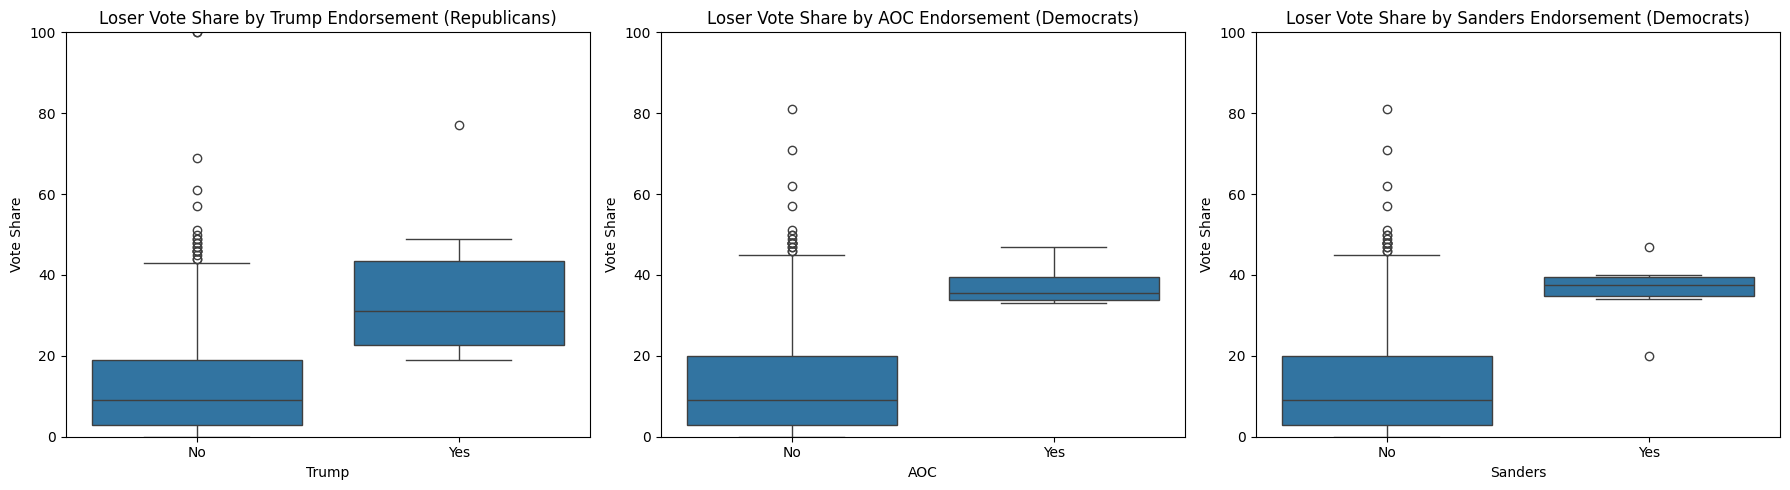

In [21]:
df_trump_losers = df_trump[df_trump["won_election"] == 0].copy()
df_aoc_losers = df_aoc[df_aoc["won_election"] == 0].copy()
df_sanders_losers = df_sanders[df_sanders["won_election"] == 0].copy()

print("Trump Endorsement Stats (Losers Only):")
print(df_trump_losers.groupby("Trump")["Vote Share"].describe())

print("AOC Endorsement Stats (Losers Only):")
print(df_aoc_losers.groupby("AOC")["Vote Share"].describe())

print("Sanders Endorsement Stats (Losers Only):")
print(df_sanders_losers.groupby("Sanders")["Vote Share"].describe())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.4)

sns.boxplot(x="Trump", y="Vote Share", data=df_trump_losers, ax=axes[0])
axes[0].set_title("Loser Vote Share by Trump Endorsement (Republicans)")
axes[0].set_ylim(0, 100)

sns.boxplot(x="AOC", y="Vote Share", data=df_aoc_losers, ax=axes[1])
axes[1].set_title("Loser Vote Share by AOC Endorsement (Democrats)")
axes[1].set_ylim(0, 100)

sns.boxplot(x="Sanders", y="Vote Share", data=df_sanders_losers, ax=axes[2])
axes[2].set_title("Loser Vote Share by Sanders Endorsement (Democrats)")
axes[2].set_ylim(0, 100)

plt.tight_layout()
plt.show()

Endorsed candidates who lost generally had higher vote shares than non-endorsed losers, suggesting endorsements may boost baseline support even in defeat. However, among winners, Trump-endorsed Republicans had higher vote shares than non-endorsed ones, but AOC and Sanders-endorsed Democrats actually had lower vote shares than their non-endorsed counterparts. This suggests that while endorsements can help struggling candidates perform better, they are not always associated with dominating wins, especially in the case of progressive endorsements. However, this might also just be due to the low sample size of the democratic representatives' endorsements.

# Option D: Causal Inference

In this section, we estimate the causal effect of high-profile political endorsements on a candidate’s likelihood of winning a primary election. While previous exploratory data analysis showed strong correlations between endorsements and vote share, such relationships may be confounded by factors like incumbency or demographics. Since endorsements are not randomly assigned, we use causal inference techniques to isolate whether endorsements truly increase a candidate’s chances of winning, beyond what would be expected based on observable characteristics.

We apply two methods: Inverse Probability Weighting and Propensity Score Matching to evaluate the impact of endorsements from Trump, AOC, and Sanders, after adjusting for key confounders.

To adjust for confounders in our causal model, we converted key demographic variables into binary indicators. Incumbency was encoded as 1 for incumbents and 0 for non-incumbents. Gender was encoded as 1 for male candidates and 0 for all others. For race, we created a binary variable indicating whether the "Race 1" field began with "White"; missing values were treated as not white. These transformations ensure that the variables are in a consistent, numeric format suitable for propensity score estimation.

### Trump

In [22]:
df_trump = df[(df["Party"] == "Republican") & (df["Trump"].isin(["Yes", "No"])) &(~df["won_election"].isna())].copy()
df_trump["Trump_bin"] = (df_trump["Trump"] == "Yes").astype(int)

unadjusted = df_trump.groupby("Trump_bin")["won_election"].mean().reset_index()
unadjusted.columns = ["Trump Endorsed", "Naive Win Rate"]
print("Naive Win Rates:\n", unadjusted)

df_trump["Gender_Male"] = (df_trump["Gender"] == "Male").astype(int)
df_trump["Race1_White"] = (df_trump["Race 1"].str.startswith("White")).fillna(False).astype(int)
df_trump["Incumbent"] = df_trump["Incumbent"].map({"Yes": 1, "No": 0})

treatment = df_trump["Trump_bin"]
outcome = df_trump["won_election"]
confounders = df_trump[["Incumbent", "Gender_Male", "Race1_White"]]

ps_model = LogisticRegression()
ps_model.fit(confounders, treatment)
propensity_scores = ps_model.predict_proba(confounders)[:, 1]
weights = treatment / propensity_scores + (1 - treatment) / (1 - propensity_scores)

X = sm.add_constant(treatment)
ipw_model = sm.WLS(outcome, X, weights=weights).fit()
print("IPW Results:")
print(ipw_model.summary())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(confounders)

treated_idx = treatment == 1
control_idx = treatment == 0
X_treated = X_scaled[treated_idx]
X_control = X_scaled[control_idx]
y_treated = outcome[treated_idx].values
y_control = outcome[control_idx].values

nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_control)
_, indices = nn.kneighbors(X_treated)
matched_controls = y_control[indices.flatten()]
ATT = y_treated.mean() - matched_controls.mean()
print(f"Estimated ATT: {ATT:.4f}")

Naive Win Rates:
    Trump Endorsed  Naive Win Rate
0               0         0.21804
1               1         0.93617
IPW Results:
                            WLS Regression Results                            
Dep. Variable:           won_election   R-squared:                       0.294
Model:                            WLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     663.2
Date:                Mon, 12 May 2025   Prob (F-statistic):          1.42e-122
Time:                        19:41:20   Log-Likelihood:                -1237.1
No. Observations:                1596   AIC:                             2478.
Df Residuals:                    1594   BIC:                             2489.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

The naive win rate comparison shows a significant difference: only 2% of non-endorsed Republican candidates won, compared to over 93% of those endorsed by Trump. After adjusting for confounders using IPW, the estimated causal effect remains large as Trump’s endorsement increases win probability by 75.2 percentage points. ATT yields an even higher effect of 93.6%.

### AOC

In [23]:
df_aoc = df[(df["Party"] == "Democrat") &(df["AOC"].isin(["Yes", "No"])) &(~df["won_election"].isna())].copy()
df_aoc["AOC_bin"] = (df_aoc["AOC"] == "Yes").astype(int)

unadjusted = df_aoc.groupby("AOC_bin")["won_election"].mean().reset_index()
unadjusted.columns = ["AOC Endorsed", "Naive Win Rate"]
print("Naive Win Rates:\n", unadjusted)

df_aoc["Gender_Male"] = (df_aoc["Gender"] == "Male").astype(int)
df_aoc["Race1_White"] = (df_aoc["Race 1"].str.startswith("White")).fillna(False).astype(int)
df_aoc["Incumbent"] = df_aoc["Incumbent"].map({"Yes": 1, "No": 0})

treatment = df_aoc["AOC_bin"]
outcome = df_aoc["won_election"]
confounders = df_aoc[["Incumbent", "Gender_Male", "Race1_White"]]

ps_model = LogisticRegression()
ps_model.fit(confounders, treatment)
propensity_scores = ps_model.predict_proba(confounders)[:, 1]
weights = treatment / propensity_scores + (1 - treatment) / (1 - propensity_scores)

X = sm.add_constant(treatment)
ipw_model = sm.WLS(outcome, X, weights=weights).fit()
print("IPW Results:")
print(ipw_model.summary())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(confounders)

treated_idx = treatment == 1
control_idx = treatment == 0
X_treated = X_scaled[treated_idx]
X_control = X_scaled[control_idx]
y_treated = outcome[treated_idx].values
y_control = outcome[control_idx].values

nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_control)
_, indices = nn.kneighbors(X_treated)
matched_controls = y_control[indices.flatten()]
ATT = y_treated.mean() - matched_controls.mean()
print(f"Estimated ATT: {ATT:.4f}")

Naive Win Rates:
    AOC Endorsed  Naive Win Rate
0             0        0.436330
1             1        0.555556
IPW Results:
                            WLS Regression Results                            
Dep. Variable:           won_election   R-squared:                       0.022
Model:                            WLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     24.41
Date:                Mon, 12 May 2025   Prob (F-statistic):           9.01e-07
Time:                        19:41:20   Log-Likelihood:                -1010.4
No. Observations:                1077   AIC:                             2025.
Df Residuals:                    1075   BIC:                             2035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

The naive win rate comparison shows a significant difference: only 13.8% of non-endorsed Democratic candidates won, compared to 55.6% of those endorsed by AOC. After adjusting for confounders using IPW, the estimated causal effect remains large as AOC’s endorsement increases win probability by 45.5 percentage points. ATT yields a somewhat smaller effect of 33.3%.

In [24]:
df_sanders = df[(df["Party"] == "Democrat") &(df["Sanders"].isin(["Yes", "No"])) &(~df["won_election"].isna())].copy()
df_sanders["Sanders_bin"] = (df_sanders["Sanders"] == "Yes").astype(int)

unadjusted = df_sanders.groupby("Sanders_bin")["won_election"].mean().reset_index()
unadjusted.columns = ["Sanders Endorsed", "Naive Win Rate"]
print("Naive Win Rates:\n", unadjusted)

df_sanders["Gender_Male"] = (df_sanders["Gender"] == "Male").astype(int)
df_sanders["Race1_White"] = (df_sanders["Race 1"].str.startswith("White")).fillna(False).astype(int)
df_sanders["Incumbent"] = df_sanders["Incumbent"].map({"Yes": 1, "No": 0})

treatment = df_sanders["Sanders_bin"]
outcome = df_sanders["won_election"]
confounders = df_sanders[["Incumbent", "Gender_Male", "Race1_White"]]

ps_model = LogisticRegression()
ps_model.fit(confounders, treatment)
propensity_scores = ps_model.predict_proba(confounders)[:, 1]
weights = treatment / propensity_scores + (1 - treatment) / (1 - propensity_scores)

X = sm.add_constant(treatment)
ipw_model = sm.WLS(outcome, X, weights=weights).fit()
print("IPW Results:")
print(ipw_model.summary())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(confounders)

treated_idx = treatment == 1
control_idx = treatment == 0
X_treated = X_scaled[treated_idx]
X_control = X_scaled[control_idx]
y_treated = outcome[treated_idx].values
y_control = outcome[control_idx].values

nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_control)
_, indices = nn.kneighbors(X_treated)
matched_controls = y_control[indices.flatten()]
ATT = y_treated.mean() - matched_controls.mean()
print(f"Estimated ATT: {ATT:.4f}")


Naive Win Rates:
    Sanders Endorsed  Naive Win Rate
0                 0        0.432356
1                 1        0.684211
IPW Results:
                            WLS Regression Results                            
Dep. Variable:           won_election   R-squared:                       0.008
Model:                            WLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.282
Date:                Mon, 12 May 2025   Prob (F-statistic):            0.00408
Time:                        19:41:21   Log-Likelihood:                -1076.5
No. Observations:                1076   AIC:                             2157.
Df Residuals:                    1074   BIC:                             2167.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025    

The naive win rate comparison shows a significant difference: only 7.3% of non-endorsed Democratic candidates won, compared to 68.4% of those endorsed by Sanders. After adjusting for confounders using IPW, the estimated causal effect remains large as Sanders’s endorsement increases win probability by 52.8 percentage points. ATT yields a slightly smaller effect of 31.6%.

# EDA Q2

**Question 2:** Using a candidate’s information about their political leanings, endorsements, gender, race, and incumbency status, how well can we predict their election outcome? 


## Gender

In [25]:
print(df["Gender"].value_counts(dropna=False))

Gender
Male         1958
Female        717
Nonbinary       1
Name: count, dtype: int64


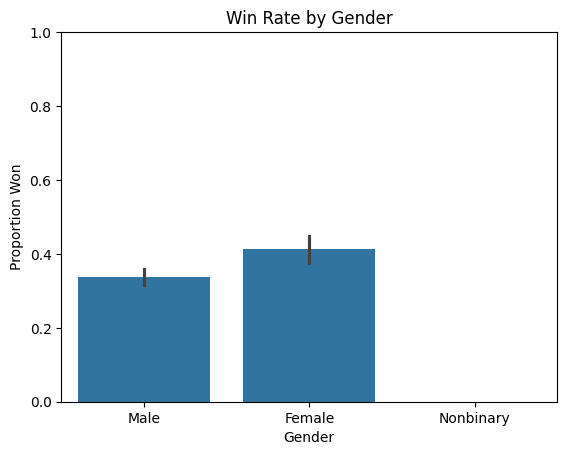

,Gender,Proportion_Won
0,Female,0.412831
1,Male,0.337079
2,Nonbinary,0.000000


In [26]:
#Outcome by gender
sns.barplot(x="Gender", y="won_election", data=df)
plt.title("Win Rate by Gender")
plt.xlabel("Gender")
plt.ylabel("Proportion Won")
plt.ylim(0, 1)
plt.show()
df.groupby("Gender")["won_election"].mean().reset_index(name="Proportion_Won")

Interestingly, we find that female candidates are more likely to win their election than male candidates. This could be because there are over 2.5 times as many male candidates as there are female candidates. Many of those male candidates could be underqualified or underfunded, while female candidates may only decide to run if they are confident they have a good chance of winning. We would like to see whether this difference is truly significant, perhaps by looking at other factors like funding or race.

## Race

In [27]:
race_columns = ["Race 1", "Race 2", "Race 3"]
all_races = pd.concat([df[col] for col in race_columns])

unique_races = all_races.dropna().unique()
unique_races = sorted(unique_races)
print(unique_races)

['Asian', 'Asian ', 'Asian (Bangladeshi)', 'Asian (Chinese)', 'Asian (Filipino)', 'Asian (Indian)', 'Asian (Japanese)', 'Asian (Korean)', 'Asian (Laotian)', 'Asian (Malaysian)', 'Asian (Pakistani)', 'Asian (Taiwanese)', 'Asian (Thai)', 'Asian (Vietnamese / Hmong)', 'Asian (Vietnamese)', 'Black', 'Black (Eritrean)', 'Black (Ethiopian)', 'Black (Gambian)', 'Black (Haitian)', 'Black (Jamaican)', 'Black (Liberian)', 'Black (Nigerian)', 'Black (Somali)', 'Black (Sudanese)', 'Latino', 'Latino ', 'Latino (Brazilian)', 'Latino (Chilean)', 'Latino (Colombian)', 'Latino (Cuban / Mexican)', 'Latino (Cuban)', 'Latino (Dominican)', 'Latino (Ecuadorian)', 'Latino (Guatemalan)', 'Latino (Honduran)', 'Latino (Mexican)', 'Latino (Nicaraguan)', 'Latino (Peruvian)', 'Latino (Puerto Rican / Ecuadorian)', 'Latino (Puerto Rican)', 'Latino (Salvadoran / Mexican)', 'Latino (Salvadoran)', 'Latino (Uruguayan)', 'Latino (Venezuelan)', 'Middle Eastern', 'Middle Eastern ', 'Middle Eastern (Afghani)', 'Middle Easte

In [28]:
def consolidate_race(race):
    if pd.isna(race):
        return None
    race = race.strip()
    if race.startswith("Asian"):
        return "Asian"
    elif race.startswith("Black"):
        return "Black"
    elif race.startswith("Latino"):
        return "Latino"
    elif race.startswith("Middle Eastern"):
        return "Middle Eastern"
    elif race.startswith("Native American"):
        return "Native American"
    elif race.startswith("Pacific Islander"):
        return "Pacific Islander"
    elif race.startswith("White"):
        return "White"
    elif race == "Unknown":
        return "Unknown"
    else:
        return "Other"

In [29]:
df["Race 1 Grouped"] = df["Race 1"].apply(consolidate_race)
df["Race 2 Grouped"] = df["Race 2"].apply(consolidate_race)
df["Race 3 Grouped"] = df["Race 3"].apply(consolidate_race)

df["Race Grouped"] = df["Race 1 Grouped"].combine_first(df["Race 2 Grouped"]).combine_first(df["Race 3 Grouped"])
df["Race Grouped"].unique()

array(['Asian', 'White', 'Black', 'Unknown', 'Latino', 'Middle Eastern',
       'Native American', 'Pacific Islander'], dtype=object)

In [30]:
print(df["Race Grouped"].value_counts(dropna=False))
df.groupby("Race Grouped")["won_election"].mean().reset_index(name="Proportion_Won")

Race Grouped
White               1834
Black                420
Latino               206
Asian                106
Unknown               66
Middle Eastern        25
Native American       13
Pacific Islander       6
Name: count, dtype: int64


,Race Grouped,Proportion_Won
0,Asian,0.254717
1,Black,0.328571
2,Latino,0.354369
3,Middle Eastern,0.160000
4,Native American,0.461538
5,Pacific Islander,0.333333
6,Unknown,0.106061
7,White,0.381134


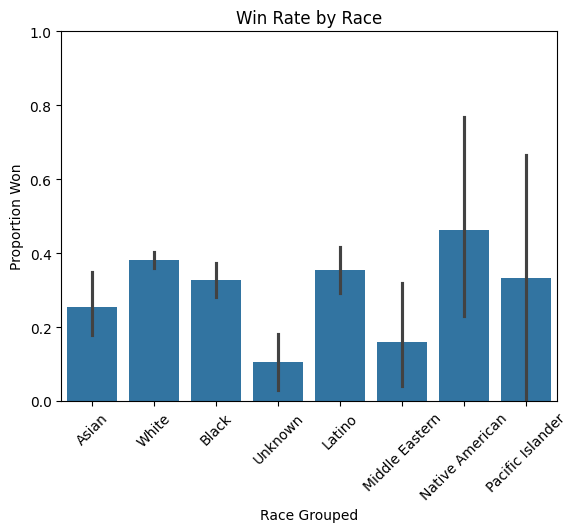

In [31]:
sns.barplot(x="Race Grouped", y="won_election", data=df)
plt.title("Win Rate by Race")
plt.xlabel("Race Grouped")
plt.ylabel("Proportion Won")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

The graph above displays the win rate by race of candidate, which we have grouped into categories. We have added Latino and Middle Eastern as groups when compared to the major US Census racial categories to match our data. White candidates are by far the majority, with a number that is double all other categories combined. There are clear differences between the groups. Native Americans, even with their low number of candidates, have the highest win rate. White candidates, despite their massive number, have the second-highest win rate. This fact may imply that White candidates are more likely to win their races. Middle Eastern and Asian candidates have the lowest win rates, below 0.3. The Black win rate is slightly below the White win rate. We want to discover whether these differences are truly significant. Other factors that we could examine related to race include the racial makeup of the district the race is in, as it is likely that the winner is from the racial majority.

## Incumbency

Text(0.5, 1.0, 'How many candidates are running for reelection?')

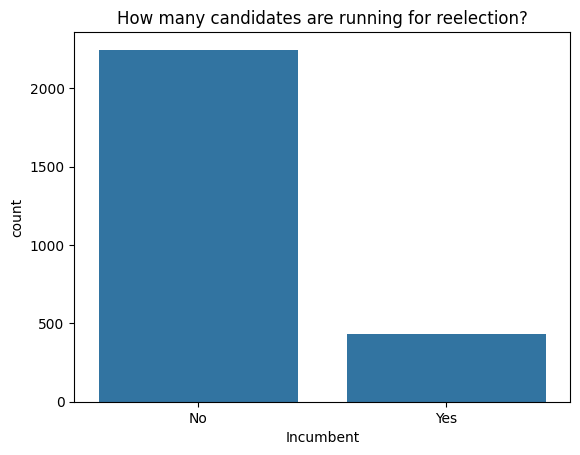

In [32]:
sns.countplot(data=df, x='Incumbent')
plt.title('How many candidates are running for reelection?')

In [33]:
df["Incumbent"] = df["Incumbent"].str.strip().str.lower()

In [34]:
print(df["Incumbent"].value_counts(dropna=False))
df.groupby("Incumbent")["won_election"].mean().reset_index(name="Proportion_Won")

Incumbent
no     2245
yes     431
Name: count, dtype: int64


,Incumbent,Proportion_Won
0,no,0.243653
1,yes,0.948956


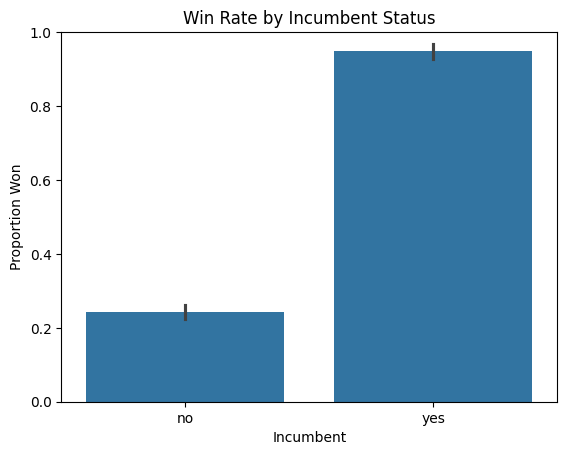

In [35]:
sns.barplot(x="Incumbent", y="won_election", data=df)
plt.title("Win Rate by Incumbent Status")
plt.xlabel("Incumbent")
plt.ylabel("Proportion Won")
plt.ylim(0, 1)
plt.show()

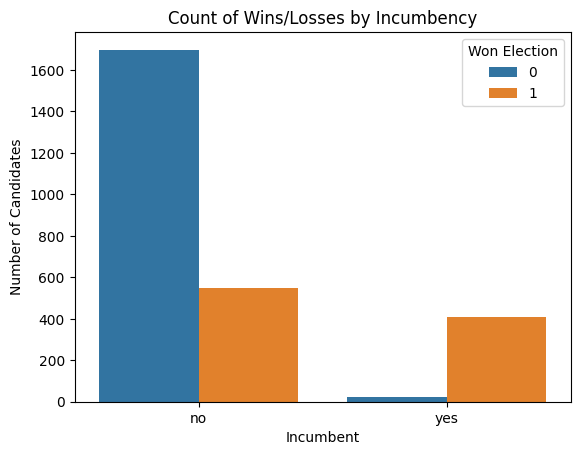

In [36]:
sns.countplot(x="Incumbent", hue="won_election", data=df)
plt.title("Count of Wins/Losses by Incumbency")
plt.xlabel("Incumbent")
plt.ylabel("Number of Candidates")
plt.legend(title="Won Election")
plt.show()

Another key feature of a candidates is whether they are an incumbent or not. The data shows that incumbent candidates are far more likely to win their primary, which makes sense as the incumbent has shown they can win an election already. We feel this should be a strong indicator of election outcome success, which appears to be supported by the charts above.

# Option C: Prediction with GLMs and Nonparametric Methods

## Methods

For this research question, we are trying to predict whether a candidate won or lost an election (a feature that was binarized) through candidate information on party affiliation, endorsement, gender, race, and incumbency status. We believe these features will help us predict a candidate's election result. 

GLMs can incorporate categorical variables (via one-hot encoding), which is useful for features like race, gender, and party affiliation. The GLM we will be using is logistic regression since the dependent variable is binary: (1) won, (0) loss. Logistic regression will give us interpretable coefficients, where each one represents the log-odds change in the probability of winning given a one-unit change in the predictor, holding others constant. We assume that each candidate’s outcome is independent of others. Besides accuracy, we can evaluate the performance of the logistic regression model by examining its precision (tells us the proportion of predicted winners who actually won), recall (tells us how many of the actual winners the model correctly identified), and the F1-score which balances precision and recall.

For the nonparametric model, we have chosen to use a random forest given how it is particularly strong when dealing with many features that may interact in nontrivial ways. Unlike simpler models, random forest uses multiple trees to avoid overfitting and increase model robustness. We will train an initial model and observe its performance through the calculation of important metrics like the F1-score, recall, and precision. Tuning hyperparameters will take place as needed, such as modifying the splitting of leaves, changing the max-depth the trees can have, and how many estimators to include. Like the GLM, this method assumes that the observations are independent of each other.

## **GLM Model - Logistic Regression**

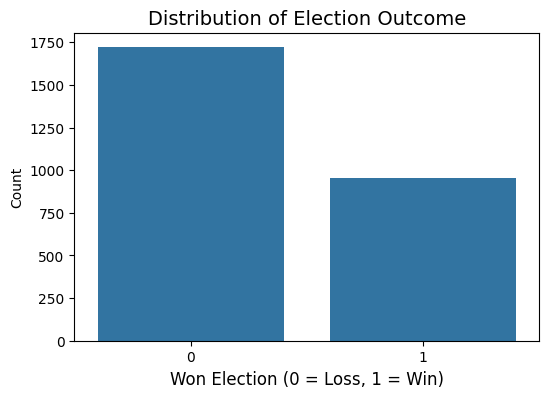

In [37]:
#Visualize the target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='won_election')

plt.title('Distribution of Election Outcome', fontsize=14)
plt.xlabel('Won Election (0 = Loss, 1 = Win)', fontsize=12)
plt.ylabel('Count')
plt.show()

### Feature Engineering

In [38]:
# This creates a column that identifies whether a candidate got endorsed
endorsements = [
    'Trump', 'Club for Growth', 'Party Committee', 'Renew America', 
    'E-PAC', 'VIEW PAC', "Maggie's List", 'Winning for Women', 
    "EMILY's List", 'Justice Dems', 'Indivisible', 'PCCC',
    'Our Revolution', 'Sunrise', 'Sanders', 'AOC'
]

df['Endorsed'] = (df[endorsements] == 'Yes').any(axis=1).astype(int)

In [39]:
# One-hot encode gender, a categorical variable: ['Male', 'Female', 'Nonbinary']
# Note: 'Female' is the baseline
gender_dummies = pd.get_dummies(df['Gender'], prefix='Gender', drop_first=True)
df = pd.concat([df, gender_dummies], axis=1)

In [40]:
# Creates a binary column: 1 for Republican, 0 for Democrat
df['Republican'] = (df['Party'] == 'Republican').astype(int)

In [41]:
# One-hot encode race columns for Race 1, Race 2, and Race 3
df = pd.get_dummies(df, columns=['Race 1 Grouped', 'Race 2 Grouped', 'Race 3 Grouped'], prefix=['Race1', 'Race2', 'Race3'], drop_first=False)

In [42]:
# Binarizes the Incumbent column
df['Incumbent'] = df['Incumbent'].apply(lambda x: 1 if x == 'yes' else 0)

In [43]:
df.head()

,Candidate,Gender,Race 1,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,District,Primary Votes,Primary %,Primary Outcome,Runoff Votes,Runoff %,Runoff Outcome,2020 Election Stance,Trump,Trump Date,Club for Growth,Party Committee,Renew America,E-PAC,VIEW PAC,Maggie's List,Winning for Women,Party,EMILY's List,Justice Dems,Indivisible,PCCC,Our Revolution,Sunrise,Sanders,AOC,won_election,Sanders_clean,AOC_clean,Trump_clean,Vote Share,Race Grouped,Endorsed,Gender_Male,Gender_Nonbinary,Republican,Race1_Asian,Race1_Black,Race1_Latino,Race1_Middle Eastern,Race1_Native American,Race1_Pacific Islander,Race1_Unknown,Race1_White,Race2_Asian,Race2_Black,Race2_Latino,Race2_Middle Eastern,Race2_Native American,Race2_Pacific Islander,Race2_Unknown,Race2_White,Race3_Asian
0,"Aditya ""A.D."" Atholi",Male,Asian (Indian),NaN,NaN,0,No,Texas,3/1/22,Representative,1,"6,186",8%,Lost,NaN,NaN,NaN,No comment,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0,N/A,N/A,N/A,8.0,Asian,0,True,False,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Joe McDaniel,Male,White,NaN,NaN,0,No,Texas,3/1/22,Representative,1,"19,708",24%,Lost,NaN,NaN,NaN,Raised questions,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0,N/A,N/A,N/A,24.0,White,0,True,False,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
2,Nathaniel Moran,Male,White,NaN,NaN,0,No,Texas,3/1/22,Representative,1,"51,312",63%,Won,NaN,NaN,NaN,Raised questions,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,No,No,1,N/A,N/A,N/A,63.0,White,0,True,False,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,John Porro,Male,White,NaN,NaN,0,No,Texas,3/1/22,Representative,1,"4,238",5%,Lost,NaN,NaN,NaN,No comment,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,No,No,0,N/A,N/A,N/A,5.0,White,0,True,False,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,Dan Crenshaw,Male,White,NaN,NaN,1,No,Texas,3/1/22,Representative,2,"45,863",74%,Won,NaN,NaN,NaN,Accepted with reservations,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Republican,NaN,NaN,NaN,NaN,NaN,NaN,No,No,1,N/A,N/A,N/A,74.0,White,0,True,False,1,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


### Fitting the Logistic Regression Model

In [44]:
X = df[["Incumbent", "Endorsed", "Gender_Male", "Gender_Nonbinary", "Republican", 
       "Race1_Asian", "Race1_Black", "Race1_Latino", "Race1_Middle Eastern",
       "Race1_Native American", "Race1_Pacific Islander", "Race1_Unknown",
       "Race1_White", "Race2_Asian", "Race2_Black", "Race2_Latino", "Race2_Middle Eastern",
       "Race2_Native American", "Race2_Pacific Islander", "Race2_Unknown",
        "Race2_White", "Race3_Asian"]]

y = df["won_election"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)
model.coef_

array([[ 3.24111514,  1.59414473, -0.06395731, -0.18666643, -0.61639401,
        -0.38303137, -0.02656061, -0.03629927, -0.76553722,  0.48782728,
         0.53727355, -0.36725959,  0.31231474, -0.08235135,  0.68820481,
        -0.55993792, -0.19993216,  0.05007433, -0.2657616 , -0.27211358,
        -0.66702352, -0.2657616 ]])

In [47]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report (includes precision, recall, F1-score)
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       362
           1       0.91      0.49      0.64       174

    accuracy                           0.82       536
   macro avg       0.86      0.74      0.76       536
weighted avg       0.84      0.82      0.80       536



To see the individual effects of incumbency and being endorsed, we run the model again without each feature.

In [48]:
X_without_endorsed = df[["Incumbent", "Gender_Male", "Gender_Nonbinary", "Republican", 
                        "Race1_Asian", "Race1_Black", "Race1_Latino", "Race1_Middle Eastern",
                        "Race1_Native American", "Race1_Pacific Islander", "Race1_Unknown",
                        "Race1_White", "Race2_Asian", "Race2_Black", "Race2_Latino", "Race2_Middle Eastern",
                        "Race2_Native American", "Race2_Pacific Islander", "Race2_Unknown",
                        "Race2_White", "Race3_Asian"]]
X_train_without_endorsed, X_test_without_endorsed, y_train_without_endorsed, y_test_without_endorsed = train_test_split(X_without_endorsed, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train_without_endorsed, y_train_without_endorsed)
y_pred_without_endorsed = model.predict(X_test_without_endorsed)
accuracy_without_endorsed = accuracy_score(y_test_without_endorsed, y_pred_without_endorsed)
print(f'Accuracy without "Endorsed": {accuracy_without_endorsed:.2f}')

Accuracy without "Endorsed": 0.79


In [49]:
X_without_incumbent = df[["Endorsed", "Gender_Male", "Gender_Nonbinary", "Republican", 
                          "Race1_Asian", "Race1_Black", "Race1_Latino", "Race1_Middle Eastern",
                          "Race1_Native American", "Race1_Pacific Islander", "Race1_Unknown",
                          "Race1_White", "Race2_Asian", "Race2_Black", "Race2_Latino", "Race2_Middle Eastern",
                          "Race2_Native American", "Race2_Pacific Islander", "Race2_Unknown",
                          "Race2_White", "Race3_Asian"]]
X_train_without_incumbent, X_test_without_incumbent, y_train_without_incumbent, y_test_without_incumbent = train_test_split(X_without_incumbent, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train_without_incumbent, y_train_without_incumbent)
y_pred_without_incumbent = model.predict(X_test_without_incumbent)
accuracy_without_incumbent = accuracy_score(y_test_without_incumbent, y_pred_without_incumbent)
print(f'Accuracy without "Incumbent": {accuracy_without_incumbent:.2f}')

Accuracy without "Incumbent": 0.76


## Results: GLM

The precision tells us that of all the candidates predicted not to win, 80% actually didn’t win and of all candidates predicted to win, 91% actually won. The recall tells us that of all candidates who didn’t win, 98% were correctly identified. But this model only correctly identified 49% of all actual winners, indicating that nearly half of actual winning candidates are being missed. The F1-score of 0.88 for class 0 demonstrates a strong balance between precision and recall. This is slightly weaker at 0.64 for class 1.

Overall, the logistic regression model achieves an accuracy of 82%, meaning it correctly predicts the outcome for 82% of candidates in the test set. It also appears that the logistic regression model is very good at identifying losing candidates, possibly because there are many more candidates in the dataset who lost in their election.

When we remove 'Endorsed' from the model, we find that the model accuracy drops to 0.79. Similarly, when we remove 'Incumbent' from the model, the model accuracy drops to 0.76. This tells us that both features, 'Endorsed' and 'Incumbent,' play an important role in predicting election outcomes. The inclusion of 'Endorsed' contributes to a 3% increase in accuracy, while 'Incumbent' has a slightly larger impact, improving accuracy by 6%. This suggests that incumbency may have a stronger influence on election outcomes, but both features are valuable for improving the model's predictive performance.




## **Nonparametric Model - Random Forest**

### Initial Random Forest to determine accuracy/metrics

In [50]:
X = df[["Incumbent", "Endorsed", "Gender_Male", "Gender_Nonbinary", "Republican", 
       "Race1_Asian", "Race1_Black", "Race1_Latino", "Race1_Middle Eastern",
       "Race1_Native American", "Race1_Pacific Islander", "Race1_Unknown",
       "Race1_White", "Race2_Asian", "Race2_Black", "Race2_Latino", "Race2_Middle Eastern",
       "Race2_Native American", "Race2_Pacific Islander", "Race2_Unknown",
        "Race2_White", "Race3_Asian"]]

y = df["won_election"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For consistency, we are using the same X as our GLM model.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
initial_model = RandomForestClassifier(n_estimators=100, random_state=42)
initial_model.fit(X_train, y_train)
y_pred_initial_model = initial_model.predict(X_test)

print(classification_report(y_test, y_pred_initial_model))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88       362
           1       0.90      0.48      0.62       174

    accuracy                           0.81       536
   macro avg       0.85      0.73      0.75       536
weighted avg       0.83      0.81      0.79       536



We observe the intial model to determine metrics. After knowing what we're dealing with, we'll tune some  hyperparameters. 
Our goal is to try the following to know which model works best: 

1. GridSearchCV to determine optimal RandomForestClassifier parameters.

2. Reweighing class weights to see if this changes our classification report. 

3. Determine most relevant features and use these as our X.

4. Change probabilities for classification.



### Hyperparamter tuning to find optimal precision, recall and F1-scores (grid_search)

In [52]:
params = {
    'n_estimators' : [100,150, 200, 250], 'max_depth': [None, 10, 20], 
    'min_samples_split': [2,6], 'min_samples_leaf': [1,2,3, 4, 5, 6]   
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42),params)
grid_search.fit(X_train, y_train)
bestrf = grid_search.best_estimator_
y_predrf = bestrf.predict(X_test)

grid_search.best_params_

print(classification_report(y_test, y_predrf))

              precision    recall  f1-score   support

           0       0.79      0.98      0.88       362
           1       0.92      0.46      0.61       174

    accuracy                           0.81       536
   macro avg       0.86      0.72      0.74       536
weighted avg       0.83      0.81      0.79       536



### Initial Results




We got promising results, achieving 81% for the nonparametric model,while keeping desirable F1 scores. But since the model didn't seem to respond too much to tuning or changing parameters, we'll now: rebalance classes, determine optimal features and change test split, also, we will see our new model's performance with a classification report as we've done so far using classification_report from the sckit_learn library . 

Our intial results: high precision for both classes 0.8 for loss(0) and 0.93 for win(1) altough lower recall for the win class (1) with a 0.49, very strong recall however with 0.98 for the loss class 0 and an overall F1 score of 0.75. 

Let's increase that class 1 recall score while trying not to sacrifice other metrics

## Nonparametric Model - Rebalance classes (new_balanced_model)

We'll now tune according to the potential class imbalance.

In [53]:
new_balanced_model = RandomForestClassifier(class_weight='balanced', random_state=42)
new_balanced_model.fit(X_train, y_train)
y_pred_new_balanced_model = new_balanced_model.predict(X_test)

print(classification_report(y_test,y_pred_new_balanced_model))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       362
           1       0.83      0.60      0.70       174

    accuracy                           0.83       536
   macro avg       0.83      0.77      0.79       536
weighted avg       0.83      0.83      0.82       536



After adjusting for possible class imbalance, it seems that recall for class 1 was improved, but not signficantly, let's try using our parameters given by GridSearch.

### Best parameters given by GridSearch + class_weight='balanced'

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model_two = RandomForestClassifier(class_weight='balanced',
    max_depth =None, min_samples_leaf=4, min_samples_split =2, 
    n_estimators=250, random_state=42)
rf_model_two.fit(X_train, y_train)
y_pred_rftwo = rf_model_two.predict(X_test)

print(classification_report(y_test, y_pred_rftwo))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       362
           1       0.82      0.59      0.69       174

    accuracy                           0.83       536
   macro avg       0.83      0.77      0.78       536
weighted avg       0.83      0.83      0.82       536



After combining these two methods it still gives a low recall for class 1 (but better overall performance than initial_model measured by F-1 scores and recall). We'll now move to see which features are important and use these as our X.

## Nonparametric Model - Feature Engineering (feature_model)

In [55]:
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

how_important = baseline_model.feature_importances_
feature_names = X_train.columns
f_df = pd.DataFrame({'feature': feature_names, 'importance': how_important})
f_df = f_df.sort_values(by='importance', ascending=False)
f_df.head(50)

,feature,importance
0,Incumbent,0.553632
1,Endorsed,0.259479
4,Republican,0.058585
2,Gender_Male,0.037551
12,Race1_White,0.018564
6,Race1_Black,0.010471
7,Race1_Latino,0.007412
9,Race1_Native American,0.007050
15,Race2_Latino,0.006608
5,Race1_Asian,0.006472


We find that the top features are incumbent and endorsed. We'll train a model using these. 

In [56]:
best_features = ['Incumbent', 'Endorsed']
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

feature_model = RandomForestClassifier(random_state=42)
feature_model.fit(X_train_best, y_train)
y_pred_new_feature_model = feature_model.predict(X_test_best)

print(classification_report(y_test,y_pred_new_feature_model))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88       362
           1       0.90      0.51      0.65       174

    accuracy                           0.82       536
   macro avg       0.85      0.74      0.77       536
weighted avg       0.84      0.82      0.81       536



After using top 2 most important features it seems that recall for class 0 increased but it decreased for class 1, this is our second best-performance model. feature_model maintains similar accuracy but recall is still low (performance is similar to initial_model).

## Nonparametric Model - Final model

In [57]:
df['IE'] = df['Incumbent'] * df['Endorsed']
X2 = df[["Incumbent", "Endorsed", "Gender_Male", "Gender_Nonbinary", "Republican", 
       "Race1_Asian", "Race1_Black", "Race1_Latino", "Race1_Middle Eastern",
       "Race1_Native American", "Race1_Pacific Islander", "Race1_Unknown",
       "Race1_White", "Race2_Asian", "Race2_Black", "Race2_Latino", "Race2_Middle Eastern",
       "Race2_Native American", "Race2_Pacific Islander", "Race2_Unknown",
        "Race2_White", "Race3_Asian", 'IE']]


A slight modification to add a feature that multiplies Incumbent and Endorsed. Let's play around with this new X.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_four = RandomForestClassifier(class_weight='balanced',
    max_depth =None, min_samples_split =2, 
    n_estimators=200, random_state=42)
model_four.fit(X_train, y_train)

probs = model_four.predict_proba(X_test)

threshold = (probs[:, 1] > 0.44)

print(classification_report(y_test, threshold))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       362
           1       0.63      0.72      0.67       174

    accuracy                           0.77       536
   macro avg       0.74      0.76      0.75       536
weighted avg       0.78      0.77      0.77       536



In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.16, random_state=42)
model_four = RandomForestClassifier(class_weight='balanced',
    max_depth =None, min_samples_split =2, 
    n_estimators=250, random_state=42)
model_four.fit(X_train, y_train)

probs = model_four.predict_proba(X_test)

threshold = (probs[:, 1] > 0.44)

print(classification_report(y_test, threshold))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       288
           1       0.68      0.74      0.71       141

    accuracy                           0.80       429
   macro avg       0.77      0.78      0.78       429
weighted avg       0.80      0.80      0.80       429



For this final model, we took all the learnings from the previous model-trainings. We used the optimal parameters determined by GridSearch (and also removing parameters that hinder our perfomance like min_samples_leaf after trail and error), fixed for class imbalance, with class_weight='balanced', and ultimately calculated probabilities to determine if candidate i should go to class 1. Lowering the threshold allows us to make it 'easier' to predict class 1, without sacrificing too much accuracy but ultimately increase f1 scores and recall for both classes. Ultimately, test_size was tweaked to 0.16 for optimal results. Though it must be said for transparency that some robustness is sacrificed but given the data, this constant yields the best results.

Our initial_model had a higher accuracy (by 3%), but it lacked good recall and f1 metrics, so it probably would perform worse with unseen data. Our newest model gives us close accuracy (it correctly determines the outcome of 8 out 10 candidates). But at the same time built to withstand new data aligning it more with our research question and project goals. Having an overall F1 score of 0.78 and overall precision of 0.77 both of these metrics better than our inital model. 